In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go
import plotly.offline as pyo
import datetime
import matplotlib.dates as mdates
import sys
sys.path.insert(1, '../../auxiliary_scripts')
from output_postprocessing import parse_methane_series, parse_layer_file, parse_univariate_file

In [2]:
#specify names of files and corresponding variable names for dataframe proessing
layer_datafile_names={'layers': 'layers  1  1.dat'}

methane_datafile_names={'methane': 'methane_series  1  1.dat'}

univariate_datafile_names = {
                  'water_temp': 'water_temp  1  1f2.dat',
                  'co2_water': 'co2_water  1  1f2.dat',
                  'ch4_water': 'methane_water  1  1f2.dat',
                  'o2_water': 'oxygen_water  1  1f2.dat',
                  'doc_water': 'DOC  1  1f2.dat',
                  'pocl_water': 'POCL  1  1f2.dat', #live POC
                  'pocd_water': 'POCD  1  1f2.dat', #dead POC
                  'phosph_water': 'phosph_water  1  1f2.dat',
                  'prodox': 'prodox  1  1f2.dat',
                  'sod': 'sod  1  1f2.dat'} #dead POC

In [3]:
#initialize arrays to store dataframes from individual runs
df_results = []
df_layers = []
df_methanes=[]

#loop through simulation directories within met-exp folder
for dir in os.listdir():
    
    df_result = pd.DataFrame()
    
    if os.path.isdir(dir) and '.' not in dir:

        run_path = os.path.join(os.getcwd(), dir, 'time_series') #full path of time series directory

        df_layer = parse_layer_file(os.path.join(run_path, layer_datafile_names['layers'])) # parse layer file containing water, ice, snow thickness
        df_methane = parse_methane_series(os.path.join(run_path, methane_datafile_names['methane'])) # parse methane output file

        #loop through variables of interest that have outputs by water layer
        for var_key in univariate_datafile_names:

            # first file will initialize results datafrome for univariate data files
            if(len(df_result)==0):
                df_result = parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key)
            # subsequent files will be perged to dataframe based on index
            else: 
                df_result = pd.merge(df_result, parse_univariate_file(os.path.join(run_path, univariate_datafile_names[var_key]), var_key))
        
        # specify pond associated with run        
        if 'unburned' in dir:
            df_result['pond'] = 'unburned'
            df_layer['pond'] = 'unburned'
            df_methane['pond'] = 'unburned'
        else:
            df_result['pond'] = 'burned'
            df_layer['pond'] = 'burned'
            df_methane['pond'] = 'burned'
        
        # specify scenario associated with run
        run = ''.join(dir.split('-')[2:])
        
        if run == '':
            df_result['run'] = 'control'
            df_layer['run'] = 'control'
            df_methane['run'] = 'control'
        else:
            df_result['run'] = run
            df_layer['run'] = run
            df_methane['run'] = run

        # append data to scenario arrays
        df_results.append(df_result)
        df_layers.append(df_layer)
        df_methanes.append(df_methane)
        
# concatenate univariate data from individual runs
df_results = pd.concat(df_results)

# replace nodata value with nan
df_results = df_results.replace(-999, np.nan)
df_results = df_results.sort_values(by='run')

# concatenate layer data from individual runs
df_layers = pd.concat(df_layers)
df_layers = df_layers.replace(-999, np.nan)

# concatenate methane data from individual runs
df_methanes = pd.concat(df_methanes)

# replace nodata value with nan
df_methanes = df_methanes.replace(-999, np.nan)
df_methanes = df_methanes.sort_values(by='run')

# merge ice layer thickness data from layer file into main dataframe
df_results = pd.merge(df_results, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m']], 
                      on = ['Date', 'run', 'pond'])

# merge ice layer thickness data from layer file into methane dataframe
df_methanes = pd.merge(df_methanes, df_layers[['Date', 'run', 'pond', 'ice layer thickness,   m']], 
                      on = ['Date', 'run', 'pond'])

#filter results for last year of data
df_results = df_results.loc[df_results['Date']>='2022-07-01']
df_methanes = df_methanes.loc[df_methanes['Date']>='2022-07-01']
df_layers = df_layers.loc[df_layers['Date']>='2022-07-01']

#average variables across depths for an alternative view of the data
df_results_depth_avg = df_results.groupby(by=['pond', 'run', 'Date']).mean().reset_index()

#filter for unfrozen depths
df_results=df_results.loc[((df_results['depth']==-1.4) & (df_results['pond']=='burned')) | ((df_results['depth']==-2.5) & (df_results['pond']=='unburned'))]

In [4]:
# add a little more info to CH4 data

#total ch4 and co2 flux
df_methanes['tot_ch4_flux'] = df_methanes['methane_turb_flux_mg/(m**2*day)'] + df_methanes['methane_ebul_mg/(m**2*day)'] + df_methanes['methane_plant_med_flux_mg/(m**2*day)']
df_methanes['tot_co2_flux'] = df_methanes['co2_turb_flux_mol/(m**2*s)'] + df_methanes['co2_ebul_mol/(m**2*s)']

df_methanes['ebullition_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_ebul_mg/(m**2*day)'].cumsum()
df_methanes['diffusion_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_turb_flux_mg/(m**2*day)'].cumsum()
df_methanes['oxidation_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_oxid_mg/(m**2*day)'].cumsum()*-1
df_methanes['production_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['methane_prod_young_mol/(m**2*s)'].cumsum()
df_methanes['emission_cumulative'] = df_methanes['ebullition_cumulative'] + df_methanes['diffusion_cumulative']

df_methanes['co2_ebullition_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['co2_ebul_mol/(m**2*s)'].cumsum()
df_methanes['co2_diffusion_cumulative'] = df_methanes.sort_values(by=['pond', 'run', 'Date']).groupby(['pond', 'run'])['co2_turb_flux_mol/(m**2*s)'].cumsum()
df_methanes['co2_emission_cumulative'] = (df_methanes['co2_ebullition_cumulative'] + df_methanes['co2_diffusion_cumulative'])*44.01*1e3*86400

# Plot layer time series

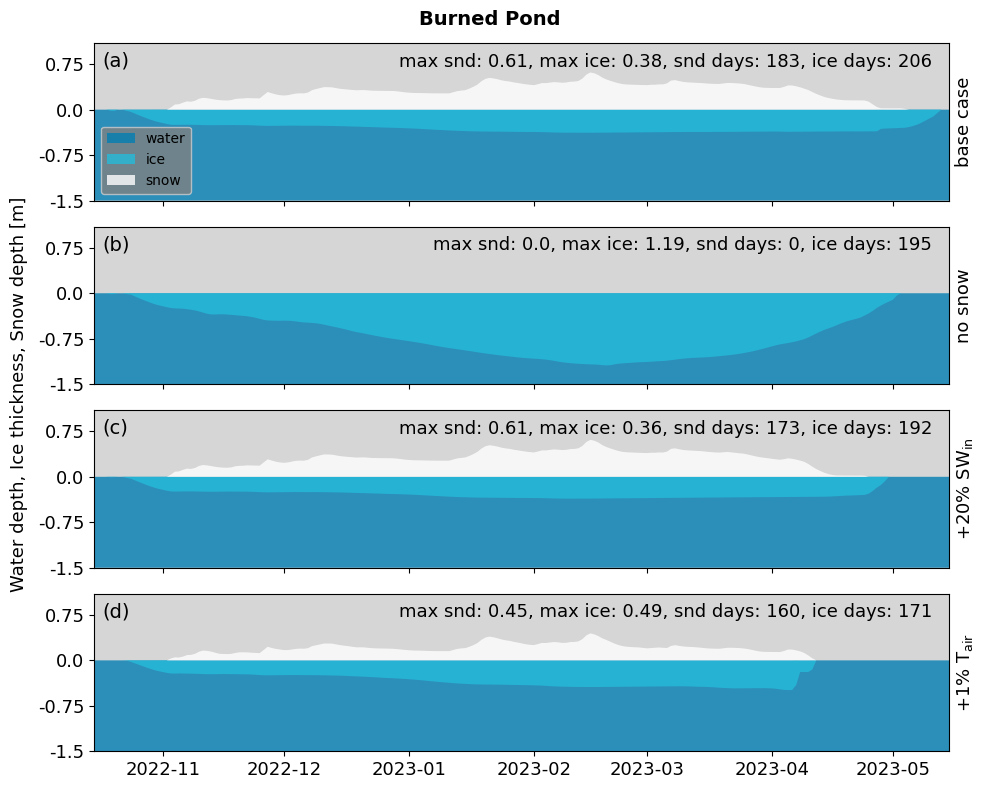

In [5]:
runs_names = df_results['run'].unique()
pond_name='burned'
run_names_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
letter_labels=['(a)', '(b)', '(c)', '(d)']

fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)

for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & (df_layers['pond']==pond_name)]

    snd_max=round(run_data['snow layer thickness,  m'][-366:].max(),2)
    max_ice=round(run_data['ice layer thickness,   m'][-366:].max(),2)
    snd=run_data['snow layer thickness,  m'][-366:].copy()
    snd_days=round(snd[snd>0].count(),2)
    ice=run_data['ice layer thickness,   m'][-366:].copy()
    ice_days=round(ice[ice>0].count(),2)
    
    axes[i].fill_between(run_data['Date'], 0, run_data['water layer thickness, m'],  
                    facecolor ='#027eb3', alpha = 0.8, label='water')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m']-run_data['ice layer thickness,   m'], run_data['water layer thickness, m'],  
                    facecolor ='#25bbd9', alpha = 0.8, label='ice')
    axes[i].fill_between(run_data['Date'], run_data['water layer thickness, m'], run_data['snow layer thickness,  m'] + run_data['water layer thickness, m'],  
                    facecolor ='white', alpha = 0.8, label='snow')

    axes[i].set_facecolor('#d6d6d6')
    
    axes[i].set_ylabel(run_names_labels[i], fontsize=13)
    axes[i].yaxis.set_label_position("right")
    axes[i].set_facecolor('#d6d6d6')
    axes[i].tick_params(axis='both', which='major', labelsize=13)
    axes[i].text(0.01, 0.85,letter_labels[i], transform=axes[i].transAxes, fontsize=14)
    
    if pond_name=='burned':
        axes[i].text(0.98, 0.85, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Burned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 0.75, 1.5, 2.25])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-1.5, -0.75, 0.0, 0.75], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')
        axes[0].set_ylim(0, 2.6)
        
    else:
        axes[i].text(0.98, 0.1, 'max snd: '+str(snd_max)+', max ice: '+str(max_ice)+
                      ', snd days: '+ str(snd_days)+', ice days: '+ str(ice_days), transform=axes[i].transAxes, fontsize=13, horizontalalignment='right')
        
        fig.suptitle('Unburned Pond', fontsize=14, fontweight='bold')
        axes[i].set_yticks([0, 1, 2, 2.75, 3.5, 4.24])  # Set the ticks to be at these values
        axes[i].set_yticklabels([-2.75, -1.75, -0.75, 0.0, 0.75, ''], fontsize=13)  # Set the tick labels with a specific fontsize

        axes[0].legend(loc='lower left', facecolor = 'grey')

        axes[0].set_ylim(0, 3.75)
        
plt.xticks(rotation=0)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Water depth, Ice thickness, Snow depth [m]', fontsize=13)
fig.tight_layout()

plt.savefig(f'met_exp_layers_{pond_name}.jpg', dpi=300)

max snd: 0.6137
max ice: 0.3809
number of snow days: 183
number of ice days: 206
-------
max snd: 0.0
max ice: 1.1914
number of snow days: 0
number of ice days: 195
-------
max snd: 0.6094
max ice: 0.3603
number of snow days: 173
number of ice days: 192
-------
max snd: 0.4455
max ice: 0.4901
number of snow days: 160
number of ice days: 171
-------


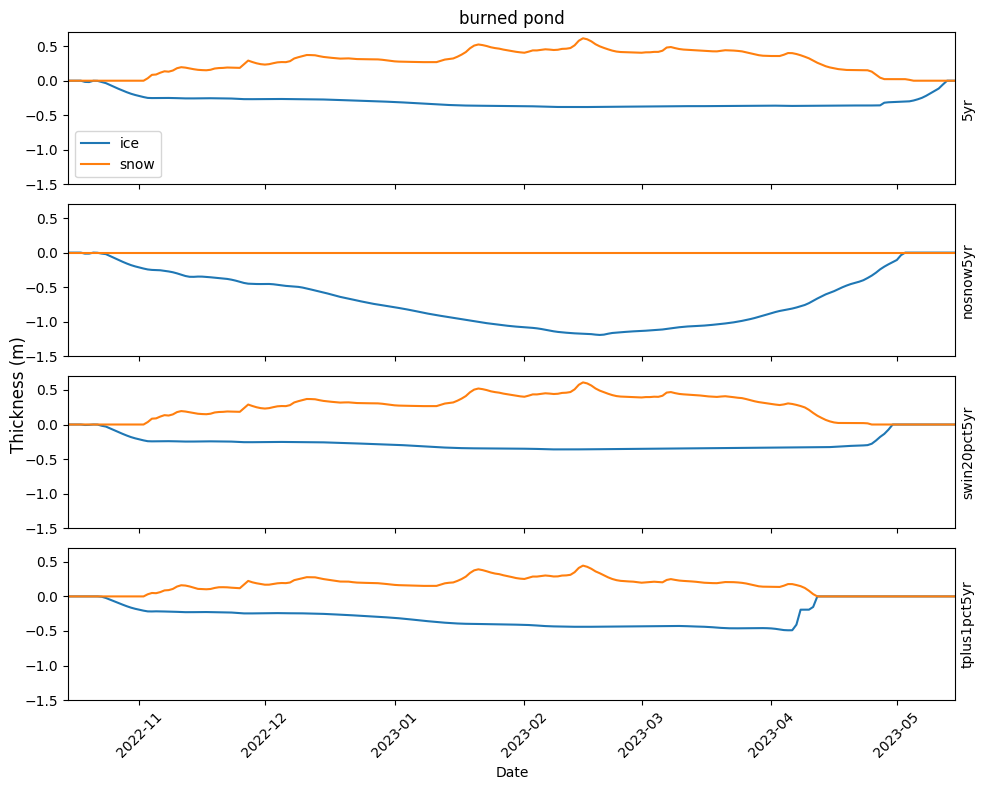

In [6]:
# another view of layers

fig, axes = plt.subplots(len(runs_names),1, figsize=(10,2*len(runs_names)), sharex=True, sharey=True)

for i, run in enumerate(runs_names):
    
    run_data = df_layers.loc[(df_layers['run']==runs_names[i]) & 
                             (df_layers['pond']==pond_name)]

    if i==0:
        axes[0].set_title(pond_name+' pond')
    #sns.lineplot(x=run_data['Date'], y=run_data['water layer thickness, m'], ax=axes[i], label='water')
    sns.lineplot(x=run_data['Date'], y=-run_data['ice layer thickness,   m'], ax=axes[i], label='ice')
    sns.lineplot(x=run_data['Date'], y=run_data['snow layer thickness,  m'], ax=axes[i], label='snow')
    #print(run_data['snow layer thickness,  m'].values)
    print('max snd:',run_data['snow layer thickness,  m'][-366:].max())
    print('max ice:',run_data['ice layer thickness,   m'][-366:].max())
    snd=run_data['snow layer thickness,  m'][-366:].copy()
    print('number of snow days:',snd[snd>0].count())
    ice=run_data['ice layer thickness,   m'][-366:].copy()
    print('number of ice days:',ice[ice>0].count())
    print('-------')

    if i!=0:
        axes[i].get_legend().remove()
        
    axes[i].set_ylabel(runs_names[i])
    axes[i].yaxis.set_label_position("right")

#axes[1].legend(loc='upper center', facecolor = 'grey')
    
plt.ylim(-1.5, 0.7)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime('2022-10-15'),pd.to_datetime('2023-05-15'))
fig.supylabel('Thickness (m)')
fig.tight_layout()

# Average water temperatures, concentrations over time, averaged across depths

In [7]:
df_results_merged_means = df_results_depth_avg.loc[(df_results_depth_avg['ice layer thickness,   m']==0) & 
                                                  (df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['co2_water', 'ch4_water', 'o2_water']].mean()
df_results_merged_stds = df_results_depth_avg.loc[(df_results_depth_avg['ice layer thickness,   m']==0) & 
                                                  (df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['co2_water', 'ch4_water', 'o2_water']].std()

In [8]:
df_results_merged_means

co2_water  ch4_water   o2_water
pond     run                                          
burned   5yr           43.432335   0.998278  10.536434
         nosnow5yr     43.042063   1.022180  10.665462
         swin20pct5yr  43.665037   0.990746  10.421515
         tplus1pct5yr  42.516043   0.961552  10.664114
unburned 5yr           95.924674   1.857382   8.706178
         nosnow5yr     94.889432   1.465398   8.792802
         swin20pct5yr  97.745313   2.964536   8.450247
         tplus1pct5yr  95.575826   0.998926   8.684258

In [9]:
df_results_merged_stds

co2_water  ch4_water  o2_water
pond     run                                         
burned   5yr            6.953408   0.988584  1.375107
         nosnow5yr      6.645110   1.466952  1.464641
         swin20pct5yr   7.896185   1.608590  1.566664
         tplus1pct5yr   7.231739   0.965299  1.516314
unburned 5yr           18.424855   5.692986  1.731088
         nosnow5yr     19.111674   4.539086  1.804294
         swin20pct5yr  21.300365  19.503384  1.909381
         tplus1pct5yr  20.222685   1.135799  1.889353

In [10]:
twater_merged_means = df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].mean()
twater_merged_stds = df_results_depth_avg.loc[(df_results_depth_avg['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['water_temp']].std()

In [11]:
twater_merged_means

water_temp
pond     run                     
burned   5yr             6.497369
         nosnow5yr       7.218386
         swin20pct5yr    7.209377
         tplus1pct5yr    7.395970
unburned 5yr             7.182521
         nosnow5yr       7.619140
         swin20pct5yr    7.821590
         tplus1pct5yr    8.010150

In [12]:
twater_merged_stds

water_temp
pond     run                     
burned   5yr             6.261700
         nosnow5yr       5.812225
         swin20pct5yr    6.749047
         tplus1pct5yr    6.431205
unburned 5yr             5.693707
         nosnow5yr       5.403171
         swin20pct5yr    6.129211
         tplus1pct5yr    5.817522

In [13]:
cumulative_ch4_yrly = df_methanes.loc[(df_methanes['Date']>'2022-07-01')].groupby(by=['pond', 'run'])[['methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)',
                                                                                                        'co2_turb_flux_mol/(m**2*s)', 'co2_ebul_mol/(m**2*s)',
                                                                                                        'tot_ch4_flux', 'tot_co2_flux']].sum().reset_index()

cumulative_ch4_yrly = pd.merge(cumulative_ch4_yrly, cumulative_ch4_yrly.loc[cumulative_ch4_yrly['run']=='5yr'], on=['pond'], suffixes=['', '_control'])
cumulative_ch4_yrly['ebul_pct_change'] = ((cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)_control']) / cumulative_ch4_yrly['methane_ebul_mg/(m**2*day)_control']) * 100
cumulative_ch4_yrly['diffuse_pct_change'] = ((cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)'] - cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_yrly['methane_turb_flux_mg/(m**2*day)_control']) * 100
cumulative_ch4_yrly['tot_ch4_flux_pct_change'] = ((cumulative_ch4_yrly['tot_ch4_flux'] - cumulative_ch4_yrly['tot_ch4_flux_control']) / cumulative_ch4_yrly['tot_ch4_flux_control']) * 100
cumulative_ch4_yrly['tot_co2_flux_pct_change'] = ((cumulative_ch4_yrly['tot_co2_flux'] - cumulative_ch4_yrly['tot_co2_flux_control']) / cumulative_ch4_yrly['tot_co2_flux_control']) * 100

In [14]:
cumulative_ch4_monthly = df_methanes.loc[(df_methanes['Date']>'2022-07-01')].groupby(by=['pond', 'run', 'month'])[['methane_ebul_mg/(m**2*day)', 'methane_turb_flux_mg/(m**2*day)',
                                                                                                                'co2_turb_flux_mol/(m**2*s)', 'co2_ebul_mol/(m**2*s)',
                                                                                                                'tot_ch4_flux', 'tot_co2_flux']].sum().reset_index()
cumulative_ch4_monthly = pd.merge(cumulative_ch4_monthly, cumulative_ch4_monthly.loc[cumulative_ch4_monthly['run']=='5yr'], on=['pond', 'month'], suffixes=['', '_control'])
cumulative_ch4_monthly['ebul_pct_change'] = ((cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)'] - cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)_control']) / cumulative_ch4_monthly['methane_ebul_mg/(m**2*day)_control']) * 100
cumulative_ch4_monthly['diffuse_pct_change'] = ((cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)'] - cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)_control']) / cumulative_ch4_monthly['methane_turb_flux_mg/(m**2*day)_control']) * 100
cumulative_ch4_monthly['tot_ch4_flux_pct_change'] = ((cumulative_ch4_monthly['tot_ch4_flux'] - cumulative_ch4_monthly['tot_ch4_flux_control']) / cumulative_ch4_monthly['tot_ch4_flux_control']) * 100
cumulative_ch4_monthly['tot_co2_flux_pct_change'] = ((cumulative_ch4_monthly['tot_co2_flux'] - cumulative_ch4_monthly['tot_co2_flux_control']) / cumulative_ch4_monthly['tot_co2_flux_control']) * 100

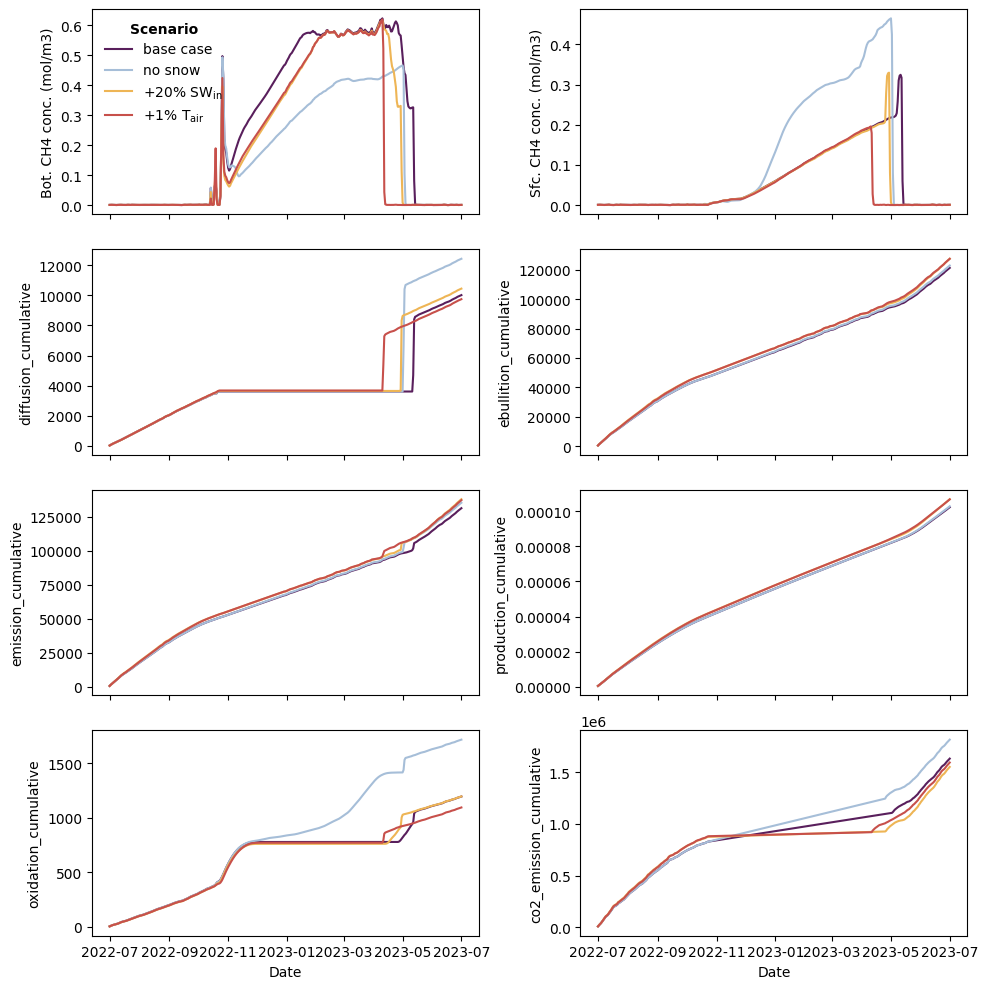

In [15]:
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

fig, axes = plt.subplots(4,2, figsize=(10, 10), sharex=True)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='lake bottom methane concentration, mol/m**3', hue='run', ax = axes[0,0], palette=pal)
axes[0,0].set_ylabel('Bot. CH4 conc. (mol/m3)')
sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='lake surface methane concentration, mol/m**3', hue='run', ax = axes[0,1], legend=False, palette=pal)
axes[0,1].set_ylabel('Sfc. CH4 conc. (mol/m3)')

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='diffusion_cumulative', hue='run', ax = axes[1,0], legend=False, palette=pal)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='ebullition_cumulative', hue='run', ax = axes[1,1], legend=False, palette=pal)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='emission_cumulative', hue='run', ax = axes[2,0], legend=False, palette=pal)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='production_cumulative', hue='run', ax = axes[2,1], legend=False, palette=pal)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='burned'], x='Date', y='oxidation_cumulative', hue='run', ax = axes[3,0], legend=False, palette=pal)

sns.lineplot(data=df_methanes.loc[df_methanes['pond']=='unburned'], x='Date', y='co2_emission_cumulative', hue='run', ax = axes[3,1], legend=False, palette=pal)


legend=axes[0,0].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper left')
new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

fig.tight_layout()

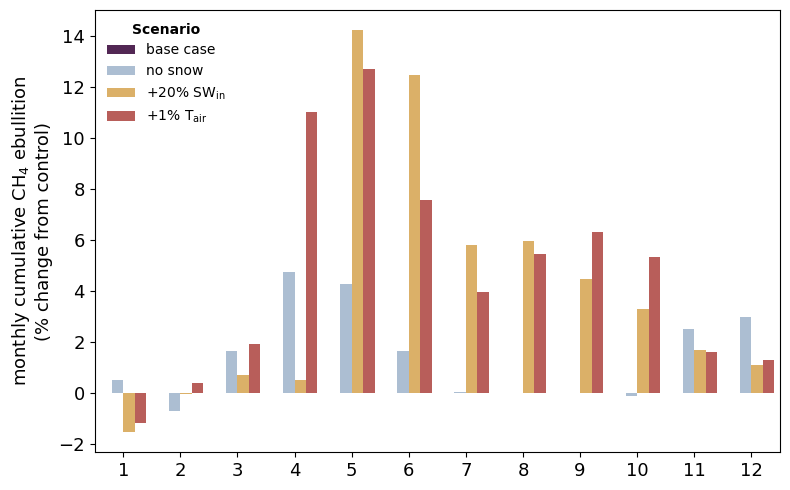

In [16]:
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=cumulative_ch4_monthly.loc[cumulative_ch4_monthly['pond']=='burned'], x='month', y='ebul_pct_change', hue='run', palette=pal)

legend=ax.legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper left')
new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
ax.set_ylabel(u'monthly cumulative $\mathregular{CH_4}$ ebullition\n(% change from control)', fontsize=13)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=13)

fig.tight_layout()
plt.savefig('monthly_cumulative_ch4_pct_change.jpg', dpi=300)

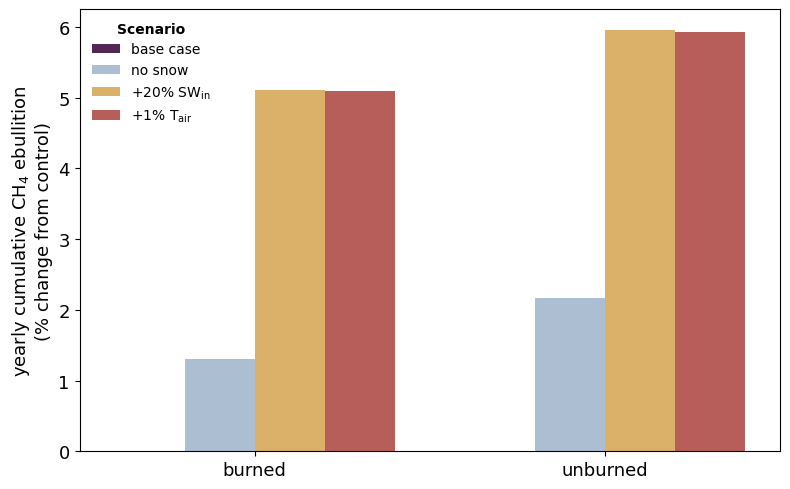

In [17]:
pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=cumulative_ch4_yrly, x='pond', y='ebul_pct_change', hue='run', palette=pal)

legend=ax.legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='upper left')
new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)
ax.set_ylabel(u'yearly cumulative $\mathregular{CH_4}$ ebullition\n(% change from control)', fontsize=13)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=13)

fig.tight_layout()
plt.savefig('yrly_cumulative_ch4_pct_change.jpg', dpi=300)

In [18]:
#reformat dataframes for box plots over ice-free and ice-on periods

#layered variables
sample_comp_melt = pd.melt(df_results.loc[(df_results['Date']>'2022-07-01') 
                           & (df_results['Date']<='2023-07-01')], 
                           id_vars=['Date', 'pond', 'run', 'ice layer thickness,   m'])

ice_free_box_data = sample_comp_melt.loc[sample_comp_melt['ice layer thickness,   m']==0]

ice_on_box_data = sample_comp_melt.loc[sample_comp_melt['ice layer thickness,   m']>0]

#methane varibles
methane_comp_melt=pd.melt(df_methanes.loc[(df_methanes['Date']>'2022-07-01') 
    & (df_methanes['Date']<='2023-07-01')], 
    id_vars=['Date', 'pond', 'run', 'ice layer thickness,   m'])

ice_free_ch4_data = methane_comp_melt.loc[methane_comp_melt['ice layer thickness,   m']==0]

ice_on_ch4_data = methane_comp_melt.loc[methane_comp_melt['ice layer thickness,   m']>0]

/tmp/ipykernel_82063/2815390629.py:32: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



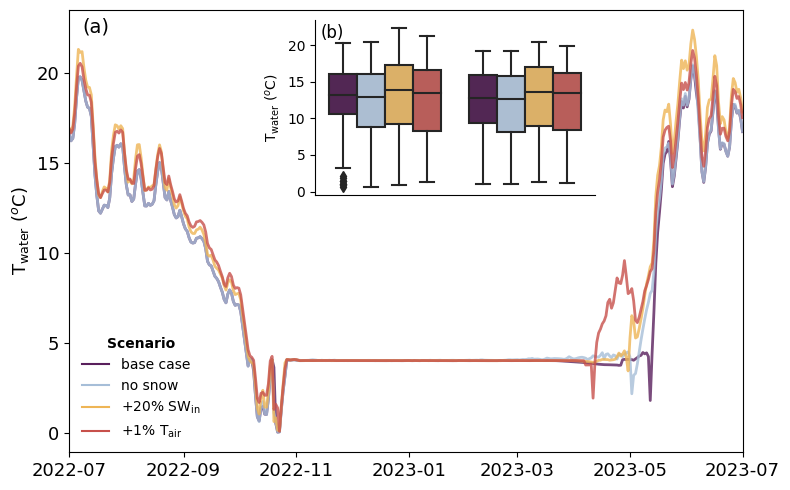

In [19]:
fig, ax = plt.subplots(figsize=(8,5), sharex=True)

pal = sns.color_palette(['#591f5c', '#A6BED8', '#EEB555', '#C7504B'])

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='water_temp', hue='run', alpha=0.8, linewidth=2, palette=pal)
ax.set_ylabel('$\mathregular{T_{water}}$ ($^o$C)', fontsize=13)
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=13)

ax.text(0.02, 0.95,'(a)', transform=ax.transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

legend=ax.legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc='lower left')
new_labels = ['base case', 'no snow', '+20% $\mathregular{SW_{in}}$', '+1% $\mathregular{T_{air}}$']
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

left1, bottom1, width1, height1 = [0.4, 0.6, 0.35, 0.35]
ax2 = fig.add_axes([left1, bottom1, width1, height1])
sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=ax2, palette=pal)
ax2.legend().remove()
ax2.set_ylabel('$\mathregular{T_{water}}$ ($^o$C)')
ax2.set_xlabel('')
ax2.spines[['right', 'top']].set_visible(False)
ax2.set_xticks([])
#ax2.set_facecolor('#d6d6d6')
ax2.text(0.02, 0.9,'(b)', transform=ax2.transAxes, fontsize=12)

fig.tight_layout()

plt.savefig('met_exp_temp_comp.jpg', dpi=300)

<Axes: xlabel='Date', ylabel='pocl_water'>

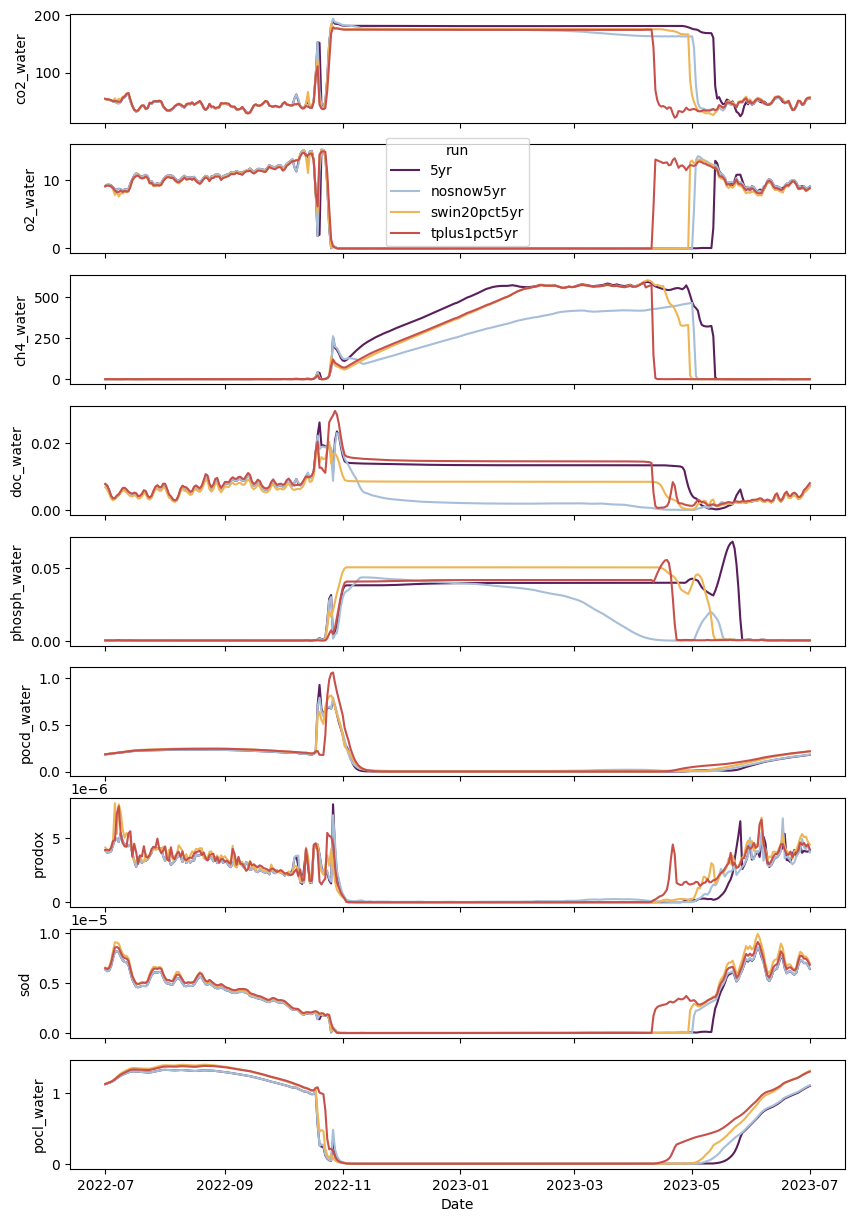

In [20]:
#full biogeochem data for burned

fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False, palette=pal)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], palette=pal)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False, palette=pal)
#axes[2].set_ylim(0,2)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False, palette=pal)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False, palette=pal)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False, palette=pal)

#axes[5].set_ylim(0,40)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False, palette=pal)

#axes[6].set_ylim(0,0.000002)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False, palette=pal)

sns.lineplot(data= df_results.loc[df_results['pond']=='burned'], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False, palette=pal)
#axes[8].set_ylim(0,.1)


(19174.0, 19539.0)

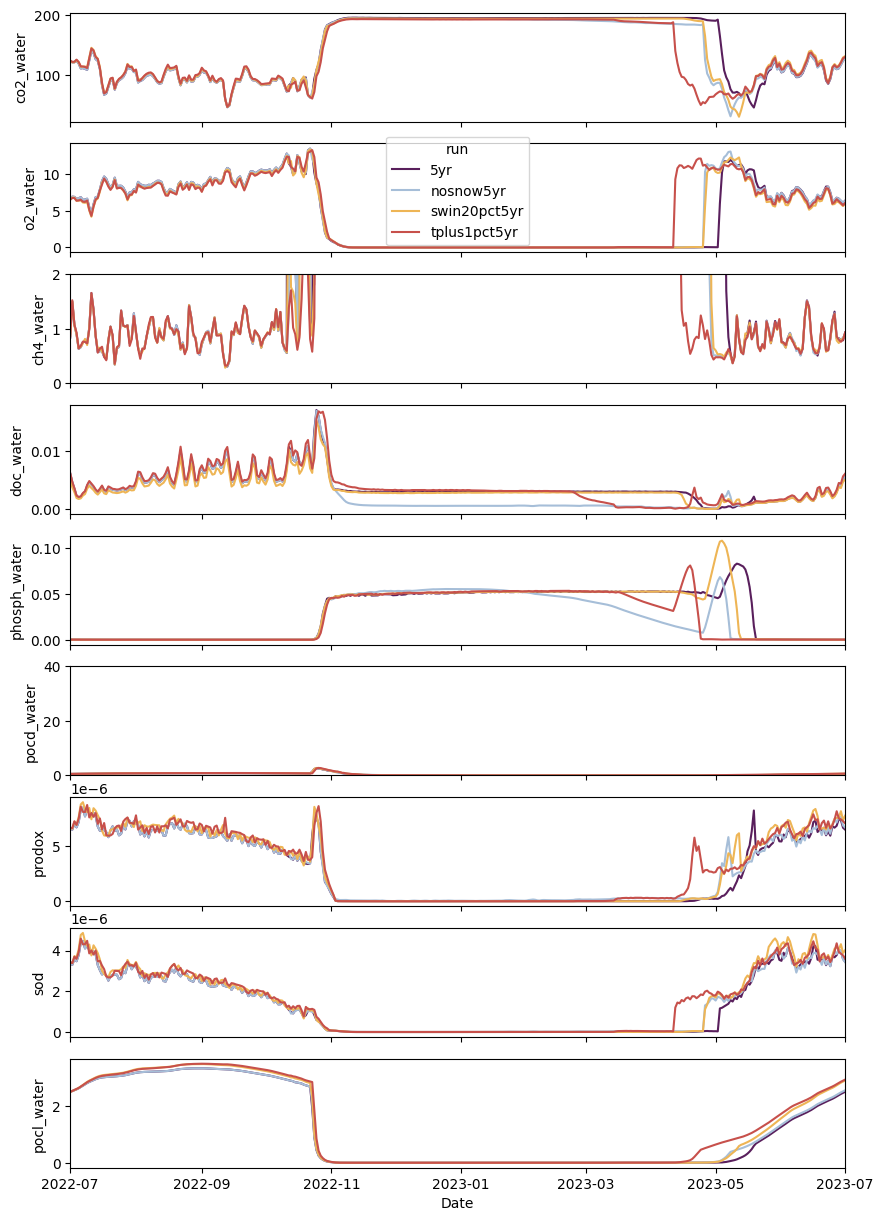

In [21]:
# full biogeochem data for unburned

pond_name='unburned'
fig, axes = plt.subplots(9, 1,figsize=(10,15), sharex=True)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='co2_water', hue='run', ax = axes[0], legend=False, palette=pal)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='o2_water', hue='run', ax = axes[1], palette=pal)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='ch4_water', hue='run', ax = axes[2], legend=False, palette=pal)
axes[2].set_ylim(0,2)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='doc_water', hue='run', ax = axes[3], legend=False, palette=pal)

#axes[4].set_ylim(0,10)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='phosph_water', hue='run', ax = axes[4], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='pocd_water', hue='run', ax = axes[5], legend=False, palette=pal)

axes[5].set_ylim(0,40)
sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='prodox', hue='run', ax = axes[6], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='sod', hue='run', ax = axes[7], legend=False, palette=pal)

sns.lineplot(data= df_results_depth_avg.loc[df_results_depth_avg['pond']==pond_name], 
                 x='Date', y='pocl_water', hue='run', ax = axes[8], legend=False, palette=pal)
plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))

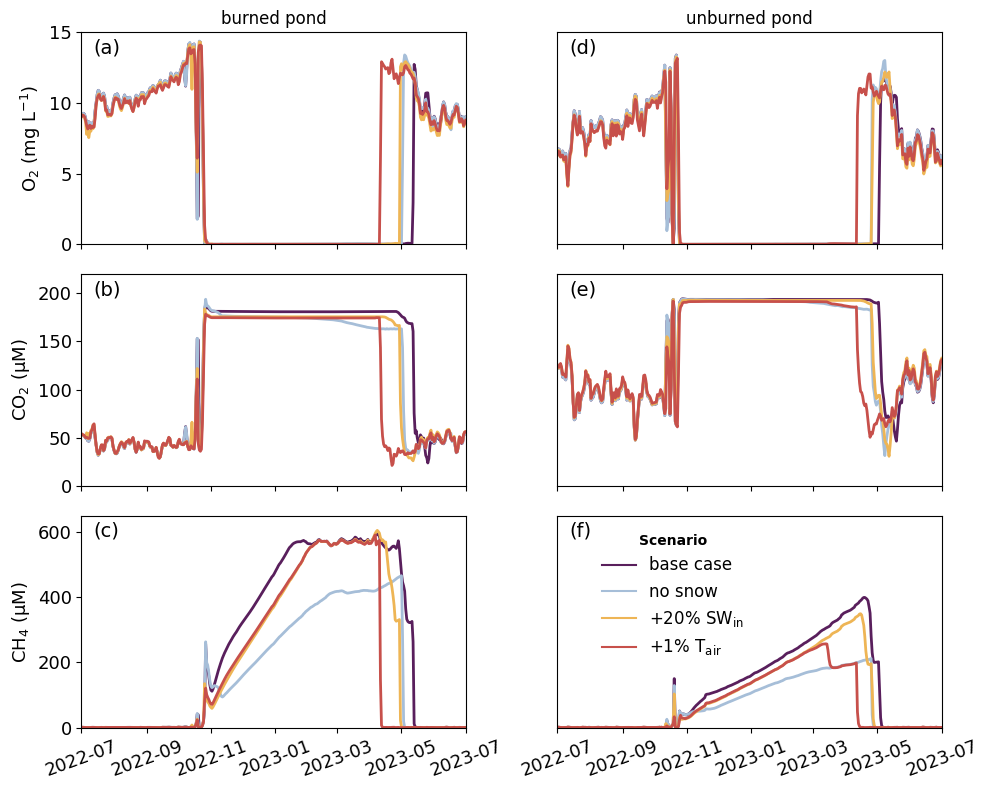

In [22]:
#main gas concentration plots
fig, axes = plt.subplots(3, 2,figsize=(10,8), sharex=True)

#Burned plots
pond_name='burned'
#fig.suptitle(pond_name+' pond') 
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='o2_water', hue='run', ax = axes[0,0], legend=False,linewidth=2, palette=pal)
axes[0,0].set_title(pond_name+' pond')
axes[0,0].set_ylabel('$\mathregular{O_2}$ (mg $\mathregular{L^{-1}}$)', fontsize=13)
axes[0,0].set_ylim(0, 15)
axes[0,0].text(0.03, 0.9,'(a)', transform=axes[0,0].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='co2_water', hue='run', ax = axes[1,0], legend=False,linewidth=2, palette=pal)
axes[1,0].set_ylabel(u'$\mathregular{CO_2}$ (\u03bcM)', fontsize=13)
axes[1,0].set_ylim(0, 220)
axes[1,0].text(0.03, 0.9,'(b)', transform=axes[1,0].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='ch4_water', hue='run', ax = axes[2,0],linewidth=2, palette=pal)
axes[2,0].set_ylabel(u'$\mathregular{CH_4}$ (\u03bcM)', fontsize=13)
axes[2,0].set_xlabel('')
axes[2,0].set_ylim(0, 650)
axes[2,0].xaxis.set_tick_params(rotation=20)
axes[2,0].text(0.03, 0.9,'(c)', transform=axes[2,0].transAxes, fontsize=14)

# Unburned plots
pond_name='unburned'
sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='o2_water', hue='run', ax = axes[0,1], legend=False,linewidth=2, palette=pal)
axes[0,1].set_title(pond_name+' pond')
axes[0,1].set_ylabel('')
axes[0,1].get_yaxis().set_visible(False)
axes[0,1].set_ylim(0, 15)
axes[0,1].text(0.03, 0.9,'(d)', transform=axes[0,1].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='co2_water', hue='run', ax = axes[1,1], legend=False,linewidth=2, palette=pal)
axes[1,1].set_ylabel('')
axes[1,1].get_yaxis().set_visible(False)
axes[1,1].set_ylim(0, 220)
axes[1,1].text(0.03, 0.9,'(e)', transform=axes[1,1].transAxes, fontsize=14)

sns.lineplot(data= df_results.loc[df_results['pond']==pond_name], 
        x='Date', y='ch4_water', hue='run', ax = axes[2,1],linewidth=2, palette=pal)
axes[2,1].set_ylabel('')
axes[2,1].set_xlabel('')
axes[2,1].get_yaxis().set_visible(False)
axes[2,1].set_ylim(0, 650)
axes[2,1].text(0.03, 0.9,'(f)', transform=axes[2,1].transAxes, fontsize=14)

plt.xlim(pd.to_datetime('2022-07-01'),pd.to_datetime('2023-07-01'))
axes[2,1].xaxis.set_tick_params(rotation=20)

legend1 = axes[2,0].legend().remove()

legend=axes[2,1].legend(title='Scenario', frameon=False, title_fontproperties={'weight':'bold'}, loc=(0.1,0.3), fontsize=12)
for text, new_label in zip(legend.get_texts(), new_labels):
    text.set_text(new_label)

axes[0,0].tick_params(axis='both', which='major', labelsize=13)
axes[1,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,0].tick_params(axis='both', which='major', labelsize=13)
axes[2,1].tick_params(axis='both', which='major', labelsize=13)

fig.tight_layout()

plt.savefig('met_exp-concentration_comp.jpg', dpi=300)

# Summer box plots

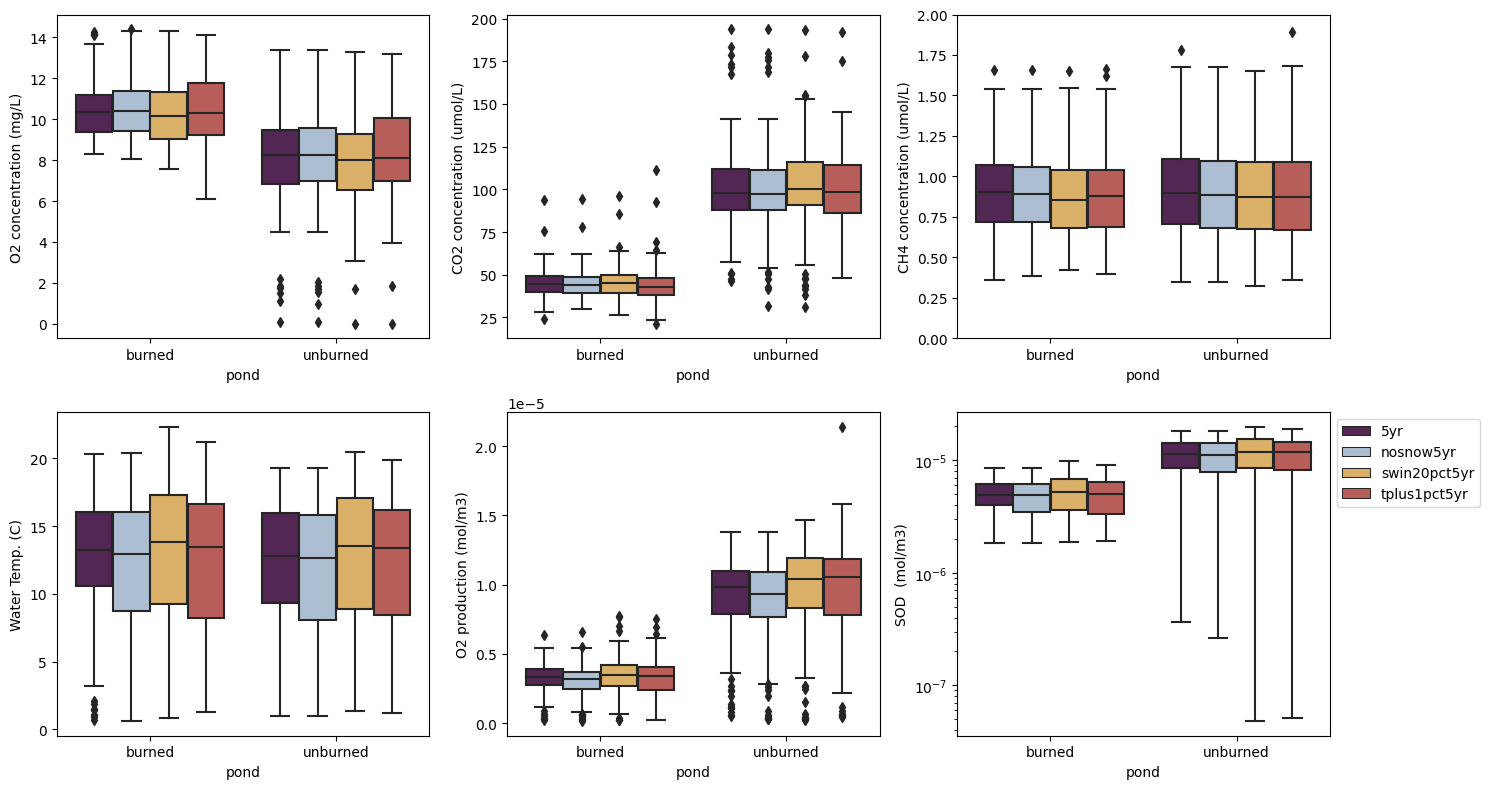

In [23]:
fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2], palette=pal)
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1], palette=pal)
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
#axes[1,1].set_yscale('log')

sns.boxplot(data=ice_free_box_data.loc[ice_free_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2], palette=pal)

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results_summer.jpg', dpi=300)

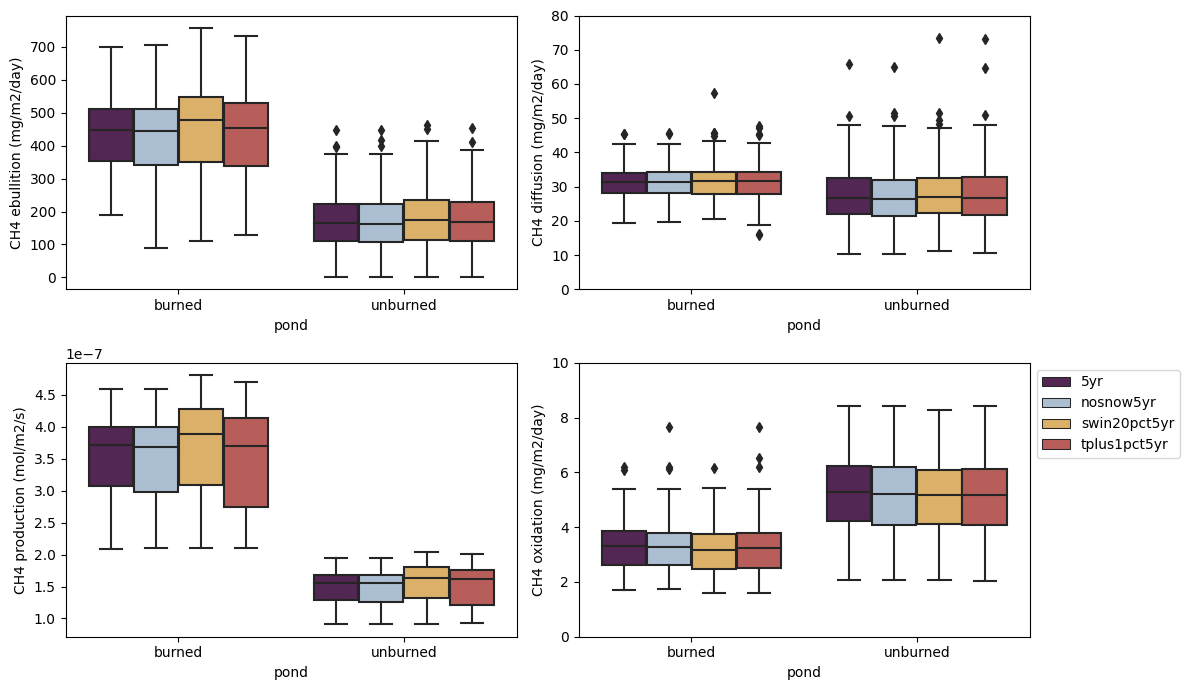

In [24]:
summer_box_data_ch4 = methane_comp_melt.loc[(methane_comp_melt['Date'].dt.month<=9) & (methane_comp_melt['Date'].dt.month>=6)]

fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
axes[0,1].set_ylim(0,80)

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=ice_free_ch4_data.loc[ice_free_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1], palette=pal)
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
axes[1,1].set_ylim(0,10)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_summer.jpg', dpi=300)

# Winter box plots

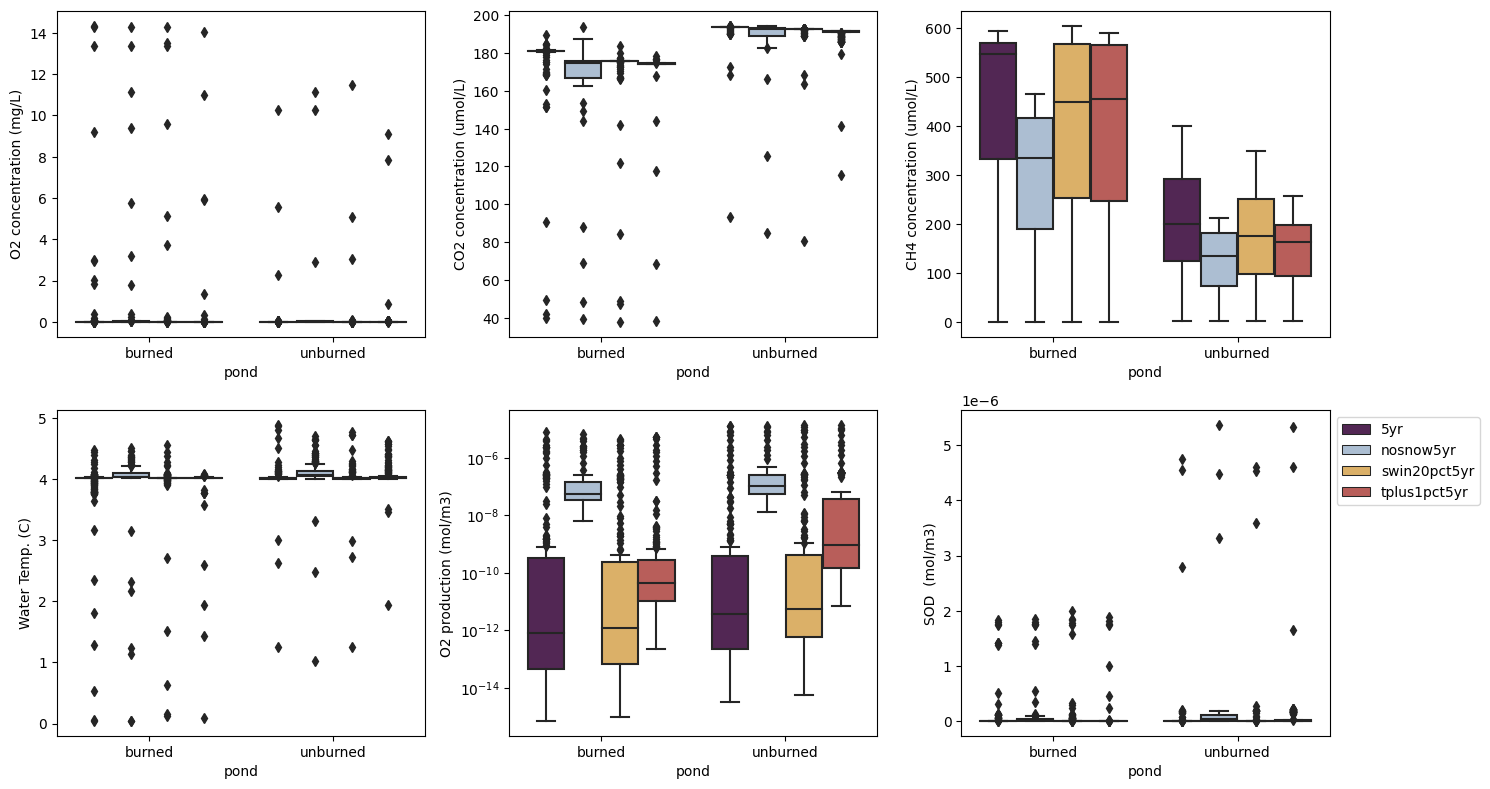

In [26]:
fig, axes=plt.subplots(2,3, figsize=(15,8))
sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'o2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].legend().remove()
axes[0,0].set_ylabel('O2 concentration (mg/L)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'co2_water'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CO2 concentration (umol/L)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'ch4_water'], 
            x='pond', y='value', hue='run', ax=axes[0,2], palette=pal)
axes[0,2].legend().remove()
axes[0,2].set_ylabel('CH4 concentration (umol/L)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'water_temp'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('Water Temp. (C)')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'prodox'], 
            x='pond', y='value', hue='run', ax=axes[1,1], palette=pal)
axes[1,1].legend().remove()
axes[1,1].set_ylabel('O2 production (mol/m3)')
axes[1,1].set_yscale('log')

sns.boxplot(data=ice_on_box_data.loc[ice_on_box_data['variable'] == 'sod'], 
            x='pond', y='value', hue='run', ax=axes[1,2], palette=pal)

axes[1, 2].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,2].set_ylabel('SOD  (mol/m3)')
#axes[1,2].set_yscale('log')
#axes[1,2].set_ylim(0,1e-6)

fig.tight_layout()
plt.savefig('met_exp_results_winter.jpg', dpi=300)

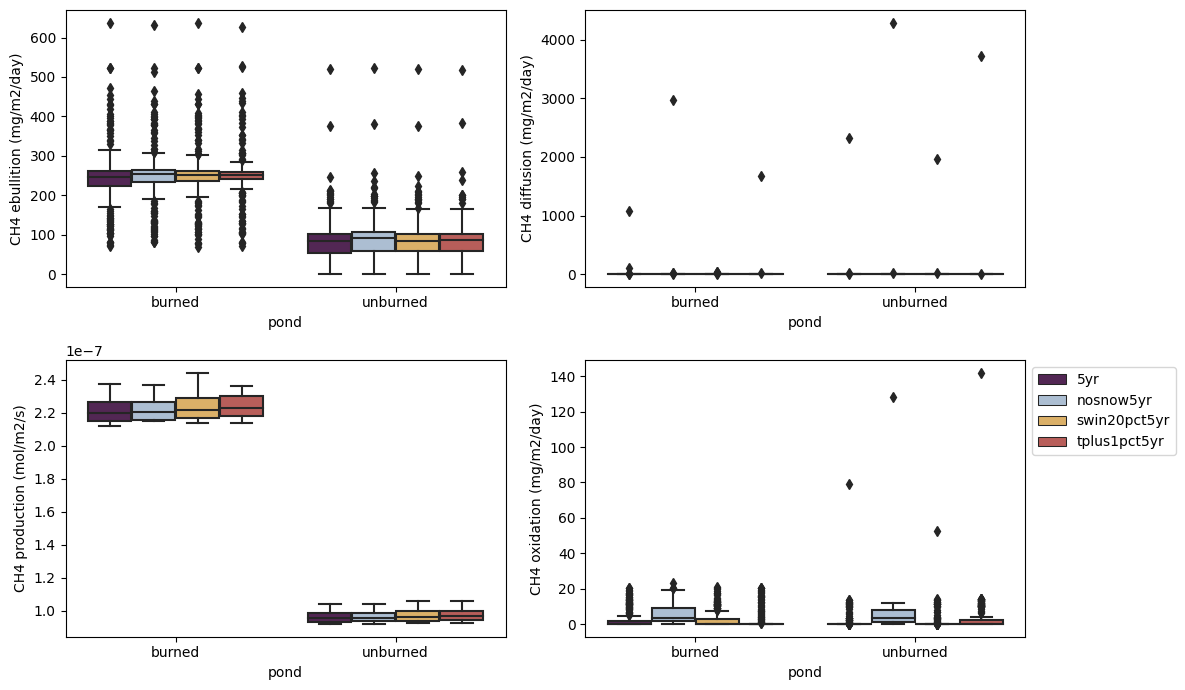

In [27]:
fig, axes=plt.subplots(2,2, figsize=(12,7))
sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_ebul_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,0], palette=pal)
axes[0,0].legend().remove()
#axes[0,0].legend(title='', loc='lower left')
axes[0,0].set_ylabel('CH4 ebullition (mg/m2/day)')

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_turb_flux_mg/(m**2*day)'], 
            x='pond', y='value', hue='run', ax=axes[0,1], palette=pal)
axes[0,1].legend().remove()
axes[0,1].set_ylabel('CH4 diffusion (mg/m2/day)')
#axes[0,1].set_ylim(0,100)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_prod_young_mol/(m**2*s)'], 
            x='pond', y='value', hue='run', ax=axes[1,0], palette=pal)
axes[1,0].legend().remove()
axes[1,0].set_ylabel('CH4 production (mol/m2/s)')
#axes[0,2].set_ylim(0,2)

sns.boxplot(data=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)'], 
            x='pond', y=ice_on_ch4_data.loc[ice_on_ch4_data['variable'] == 'methane_oxid_mg/(m**2*day)']['value']*-1, hue='run', ax=axes[1,1], palette=pal)
#axes[1,1].legend().remove()
axes[1,1].legend(title='', loc='upper left', bbox_to_anchor=(1, 1))
axes[1,1].set_ylabel('CH4 oxidation (mg/m2/day)')
#axes[1,1].set_ylim(0,1e-2)
#axes[1,1].set_yscale('log')

fig.tight_layout()
plt.savefig('met_exp_ch4_results_winter.jpg', dpi=300)

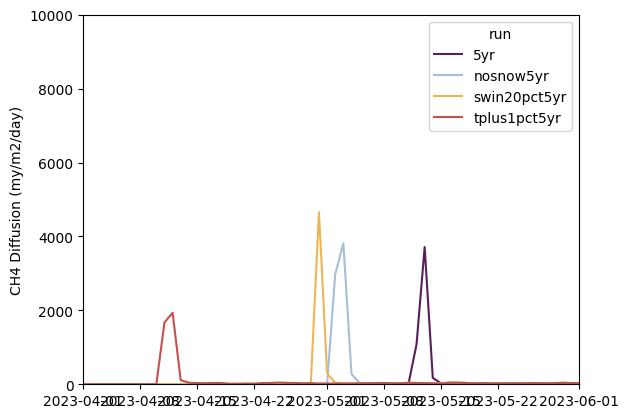

In [28]:
#pulse timing for ice breakup flux, burned
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_turb_flux_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='burned')], 
                 x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal)
plt.ylim(0,10000)
plt.xlim(pd.to_datetime('2023-04-01'),pd.to_datetime('2023-06-01'))
plt.ylabel('CH4 Diffusion (my/m2/day)')
plt.xlabel('')

plt.savefig('CH4_diffusion_burned.jpg', dpi=300)

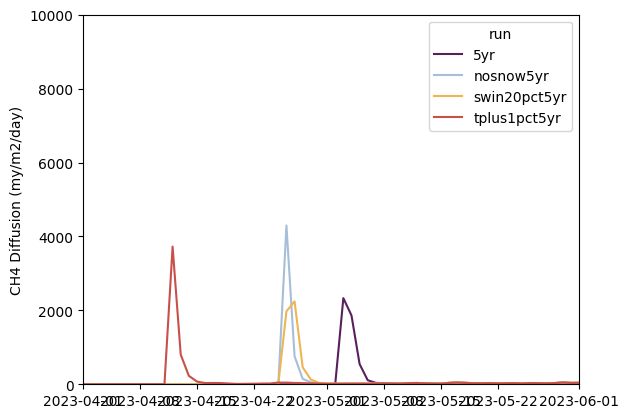

In [29]:
#pulse timing for ice breakup flux, unburned
sns.lineplot(data= df_methanes.loc[(df_methanes['methane_turb_flux_mg/(m**2*day)']!=-999)& 
                                   (df_methanes['pond']=='unburned')], 
                 x='Date', y='methane_turb_flux_mg/(m**2*day)', hue='run', palette=pal)
plt.ylim(0,10000)
plt.xlim(pd.to_datetime('2023-04-01'),pd.to_datetime('2023-06-01'))
plt.ylabel('CH4 Diffusion (my/m2/day)')
plt.xlabel('')

plt.savefig('CH4_diffusion_unburned.jpg', dpi=300)